In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import math
import random
import matplotlib.pyplot as plt

# Plotting

## Creating a plot df for t=1

In [ ]:
# Importing original df

original_df = pd.read_csv("data/final.csv", usecols=["Exchange.Date", "logreturns", "Close"])

In [ ]:
# configurations
n_seq = 63
test_share = 0.25
n_test = int(len(original_df) * test_share)

In [ ]:
original_df['Exchange.Date'] = original_df['Exchange.Date'].apply(lambda x: date(1900, 1, 1) + timedelta(int(x)))
original_df.index = original_df['Exchange.Date']

In [ ]:
# Assigning all rows in train df (before forecast) to closing value
# This is because this column cannot be empty (and we have no forecasts since it's training data)

train_df = original_df[:-n_test].copy()
train_df["forecast"] = train_df["Close"]
train_df["lower"] = train_df["Close"]
train_df["upper"] = train_df["Close"]

In [ ]:
# Transforming logreturns back to price
start = 0
end = 63

r_cross_df = pd.read_csv('data/r_cross_val.csv')
price_forecasts = r_cross_df[start:end]['forecast']
lower_pred = r_cross_df[start:end]['lower']
upper_pred = r_cross_df[start:end]['upper']

In [ ]:
# Creating a separate dataframe only for forecasts

forecast_df = pd.DataFrame(columns=["Exchange.Date", "Close", "logreturns", "forecast", "lower", "upper"])
forecast_df["Close"] = original_df["Close"].values[-n_test : -n_test + n_seq]
forecast_df["logreturns"] = original_df["logreturns"].values[-n_test : -n_test + n_seq]
forecast_df["forecast"] = price_forecasts
forecast_df["lower"] = lower_pred
forecast_df["upper"] = upper_pred
forecast_df["Exchange.Date"] = forecast_df.index.map(lambda x: date(2016, 8, 1) + timedelta(int(x)))

forecast_df.index = forecast_df["Exchange.Date"]

In [ ]:
# Merging train and forecast dataframe

merged_df = train_df.append(forecast_df, ignore_index=True)

## Generating plot

In [ ]:
plot_df = merged_df[-n_seq - (n_seq * 2) :] # -n_seq controls how many to show before the forecast (blue) line
plt.figure(figsize=(10, 5))
plt.plot(plot_df['Exchange.Date'], plot_df["forecast"], label="forecast", color="black", linestyle='--')
plt.plot(plot_df['Exchange.Date'], plot_df["Close"], label="actual", color="gray")
plt.xlabel('Tid')
plt.ylabel('Indexvärde') 
plt.title('ARMA-GARCH-prediktion vid enskild tillfälle')
plt.legend()
# plt.savefig('img/arma_garch_pred.png')

In [ ]:
# With Prediction Intervals

plot_df = merged_df[-n_seq - (n_seq * 2) :] # -n_seq controls how many to show before the forecast (blue) line

plt.figure(figsize=(10, 5))
plt.plot(plot_df['Exchange.Date'], plot_df["forecast"], label="forecast", color="black", linestyle='--')
plt.fill_between(plot_df['Exchange.Date'], plot_df['lower'], plot_df['upper'], color='black', alpha=0.1, label='95% PI')
plt.plot(plot_df['Exchange.Date'], plot_df["Close"], label="actual", color="gray")
plt.xlabel('Tid')
plt.ylabel('Indexvärde') 
plt.title('ARMA-GARCH-prediktion vid enskild tillfälle inklusive prediktionsintervall')
plt.legend(loc=2)
plt.savefig('img/arma_garch_pred_interval.png')

## Plotting different prediction for testing purposes

660


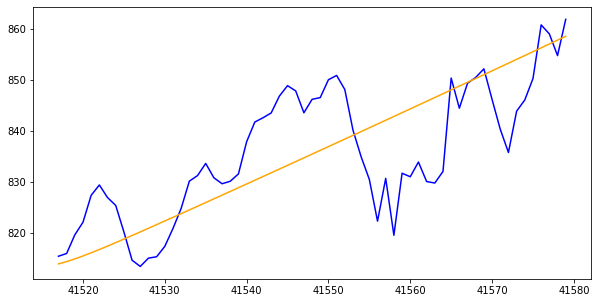

In [18]:
r_cross_df = pd.read_csv('data/r_cross_val.csv')

random_t = random.randint(1,1000)
print(random_t)

t = random_t # 205 shows interesting pattern
test_df = r_cross_df[r_cross_df['time'] == t]

plt.figure(figsize=(10, 5))
plt.plot(test_df['Close'], color="blue")
plt.plot(test_df['forecast'], color="orange")

# Cross-validation
Outdated, see new_cross_ag

## Reading CSV and assigning columns

In [19]:
# Reading r_cross_val.csv

r_cross_df = pd.read_csv('data/r_cross_val.csv')

In [20]:
# adding first row of data based on last row of test data

new_data = []
new_data.insert(0, {'time':0, 'Close': 621.38, 'forecast': 621.38, 'upper': 621.38, 'lower': 621.38})
r_cross_df = pd.concat([pd.DataFrame(new_data), r_cross_df], ignore_index=True)

In [21]:
# creating error and up columns 
r_cross_df['error'] = r_cross_df['forecast'] - r_cross_df['Close']
r_cross_df['abs_error'] = np.abs(r_cross_df['forecast'] - r_cross_df['Close'])
r_cross_df['actual_up'] = r_cross_df['Close'].diff(1) > 0
r_cross_df['forecast_up'] = r_cross_df['forecast'].diff(1) > 0

In [22]:
# creating confusion column

def confusion(actual, forecast):
    if (actual and forecast):
        return 'TP'
    
    if (actual and not forecast):
        return 'FN'
    
    if (not actual and forecast):
        return 'FP'
    
    if (not actual and not forecast):
        return 'TN'
    
    return False

r_cross_df['confusion'] = r_cross_df.apply(lambda x: confusion(x['actual_up'], x['forecast_up']), axis=1)

In [25]:
# Displaying the first 3 rows
# Note that the first row is equal to the last one in the training data

r_cross_df.head(10)

,time,Close,forecast,upper,lower,error,abs_error,actual_up,forecast_up,confusion
0,0,621.38,621.380000,621.380000,621.380000,0.000000,0.000000,False,False,TN
1,1,622.77,622.745083,630.741043,614.850489,-0.024917,0.024917,True,True,TP
2,1,618.70,623.922645,640.276720,607.986288,5.222645,5.222645,False,True,FP
3,1,617.12,624.955354,649.999267,600.876362,7.835354,7.835354,False,True,FP
4,1,621.28,625.876251,659.922484,593.586507,4.596251,4.596251,True,True,TP
5,1,622.31,626.710896,670.059638,586.166551,4.400896,4.400896,True,True,TP
6,1,624.10,627.479048,680.422615,578.655011,3.379048,3.379048,True,True,TP
7,1,624.98,628.195977,691.021708,571.082183,3.215977,3.215977,True,True,TP
8,1,624.87,628.873477,701.865690,563.472265,4.003477,4.003477,False,True,FP
9,1,629.85,629.520656,712.962007,555.844845,-0.329344,0.329344,True,True,TP


## Creating cross evaluation scores for each of the 1000 periods

In [ ]:
# Creating a dataframe with all the columns needed

cross_df = pd.DataFrame(columns=[
    "mape_1", 
    "mape_3",
    "mape_5",
    "mape_21",
    "mape_63",
    "rmse_1",
    "rmse_3",
    "rmse_5",
    "rmse_21",
    "rmse_63",
    'precision_1',
    'precision_3',
    'precision_5',
    'precision_21',
    'precision_63',
    'recall_1',
    'recall_3',
    'recall_5',
    'recall_21',
    'recall_63',
    'fscore_1',
    'fscore_3',
    'fscore_5',
    'fscore_21',
    'fscore_63',
])

In [ ]:
# Cross evaluation function

def cross_evaluate(df, n_periods):
    df = df[ : n_periods]
    mape = ((df["abs_error"] / df["Close"]).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df["error"].sum(), 2) / n_periods)

    tp = len(df[df['confusion'] == 'TP'])
    fp = len(df[df['confusion'] == 'FP'])
    fn = len(df[df['confusion'] == 'FN'])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # if else för att undvika division by zero errror
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fscore = (2*precision*recall)/(precision+recall) if (precision + recall > 0) else 0

    return mape, rmse, precision, recall, fscore

In [ ]:
# For every 63 forecasts of the 1000 periods forecasted, create scores

forecast_len = 1000
for i in range(forecast_len):
    cross_merged_df = r_cross_df[r_cross_df['time'] == i+1] # since indexing starts at 1
    one = cross_evaluate(cross_merged_df, 1)
    three = cross_evaluate(cross_merged_df, 3)
    five = cross_evaluate(cross_merged_df, 5)
    twentyone = cross_evaluate(cross_merged_df, 21)
    sixtythree = cross_evaluate(cross_merged_df, 63)

    cross_df = cross_df.append({
        'mape_1': one[0],
        'mape_3': three[0],
        'mape_5': five[0],
        'mape_21': twentyone[0],
        'mape_63': sixtythree[0],
        'rmse_1': one[1],
        'rmse_3': three[1],
        'rmse_5': five[1],
        'rmse_21': twentyone[1],
        'rmse_63': sixtythree[1],
        'precision_1': one[2],
        'precision_3': three[2],
        'precision_5': five[2],
        'precision_21': twentyone[2],
        'precision_63': sixtythree[2],
        'recall_1': one[3],
        'recall_3': three[3],
        'recall_5': five[3],
        'recall_21': twentyone[3],
        'recall_63': sixtythree[3],
        'fscore_1': one[4],
        'fscore_3': three[4],
        'fscore_5': five[4],
        'fscore_21': twentyone[4],
        'fscore_63': sixtythree[4],
    }, ignore_index=True)

    step = i % 100
    if step == 0:
        print(i, end=" ")

print('done!')

In [ ]:
# Only the results when t=1

cross_df[:1].transpose()

## Description of RMSE and MAPE

In [ ]:
#cross_df.iloc[:, :10].describe()

## Description of precision, recall and fscore

In [ ]:
# cross_df.iloc[:, 10:].describe()

## Confidence intervals for RMSE, MAPE, precision, recall and fscore

In [ ]:
n = cross_df.count()[0]
mean = cross_df.mean()
upper = cross_df.mean() + 1.64 * cross_df.std() / math.sqrt(n)
lower = cross_df.mean() - 1.64 * cross_df.std() / math.sqrt(n)

ci_df = pd.DataFrame(columns=['measure', 'mean', 'lower', 'upper'])

for i in range(25):
    ci_df = ci_df.append({
        'measure': cross_df.columns[i],
        'mean': mean[i],
        'lower': lower[i],
        'upper': upper[i]
    }, ignore_index=True)

ci_df